<a href="https://colab.research.google.com/github/NAYANDEEPSINGH/Machine-Learning-Projects/blob/main/Nayandeep_Singh_IIQF_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Q-1

Take Indian Mibor Rate and get interest rate for 3.5 year, 4.5 year and 5.5 year period
using below two models. To generate parameters of model, use historical data of last 2
years. Plot the graphs and also suggest which one is better and why?

a. Vasicek Model

b. Hull-White Model

In [ ]:
# synthetic data for 2 years.


In absence of freely accessible high-resolution MIBOR data, I simulated a short rate time series using the Vasicek model.

                          Date      Rate
499 2025-06-20 18:03:48.604412  0.068173
500 2025-06-23 18:03:48.604412  0.067300
501 2025-06-24 18:03:48.604412  0.067882
502 2025-06-25 18:03:48.604412  0.069083
503 2025-06-26 18:03:48.604412  0.068200


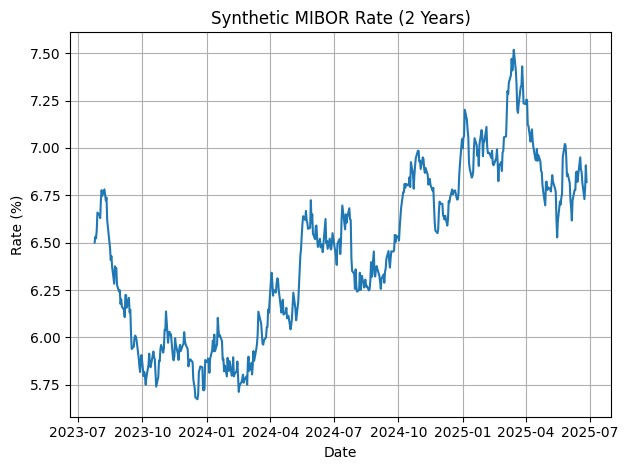

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Simulation parameters
np.random.seed(42)# same result every time
n_days = 504
dt = 1/252  # daily steps
r0 = 0.065
theta = 0.065
kappa = 0.15
sigma = 0.01

rates = [r0]
for _ in range(n_days-1):
    dr = kappa * (theta - rates[-1]) * dt + sigma * np.sqrt(dt) * np.random.normal()
    rates.append(rates[-1] + dr)

dates = pd.date_range(end=pd.Timestamp.today(), periods=n_days, freq='B') # freq='B' means business days only (no weekends).
df = pd.DataFrame({'Date': dates, 'Rate': rates})

# Preview
print(df.tail())

# Plot
plt.plot(df['Date'], df['Rate'] * 100)
plt.title("Synthetic MIBOR Rate (2 Years)")
plt.ylabel("Rate (%)")
plt.xlabel("Date")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
df.head()

,Date,Rate
0,2023-07-24 18:03:48.604412,0.065000
1,2023-07-25 18:03:48.604412,0.065313
2,2023-07-26 18:03:48.604412,0.065226
3,2023-07-27 18:03:48.604412,0.065633
4,2023-07-28 18:03:48.604412,0.066593


In [ ]:
df.tail()

,Date,Rate
499,2025-06-20 18:03:48.604412,0.068173
500,2025-06-23 18:03:48.604412,0.067300
501,2025-06-24 18:03:48.604412,0.067882
502,2025-06-25 18:03:48.604412,0.069083
503,2025-06-26 18:03:48.604412,0.068200


In [ ]:
df.shape

(504, 2)

In [ ]:
import numpy as np
from sklearn.linear_model import LinearRegression

# Use previous synthetic df from simulation
df = df.copy()
df = df.sort_values('Date').reset_index(drop=True)

# Discretization
r_t = df['Rate'].values[:-1]# r_t: today's rate
r_t1 = df['Rate'].values[1:]# r_{t+1}: next day's rate
dt = 1/252

# Target and predictor for linear regression
X = r_t.reshape(-1, 1)
#LinearRegression() expects a 2D array


y = (r_t1 - r_t) / dt

# Linear regression: y = a*(-r_t) + ab
reg = LinearRegression().fit(X, y)
a_est = -reg.coef_[0]
b_est = reg.intercept_ / a_est

# Estimate sigma (std of residuals)
residuals = y - reg.predict(X)
sigma_est = np.std(residuals) * np.sqrt(dt)

print(f"Estimated a (mean reversion speed): {a_est:.4f}")
print(f"Estimated b (long-term mean): {b_est:.4f}")
print(f"Estimated sigma (volatility): {sigma_est:.4f}")


Estimated a (mean reversion speed): 2.2865
Estimated b (long-term mean): 0.0652
Estimated sigma (volatility): 0.0098


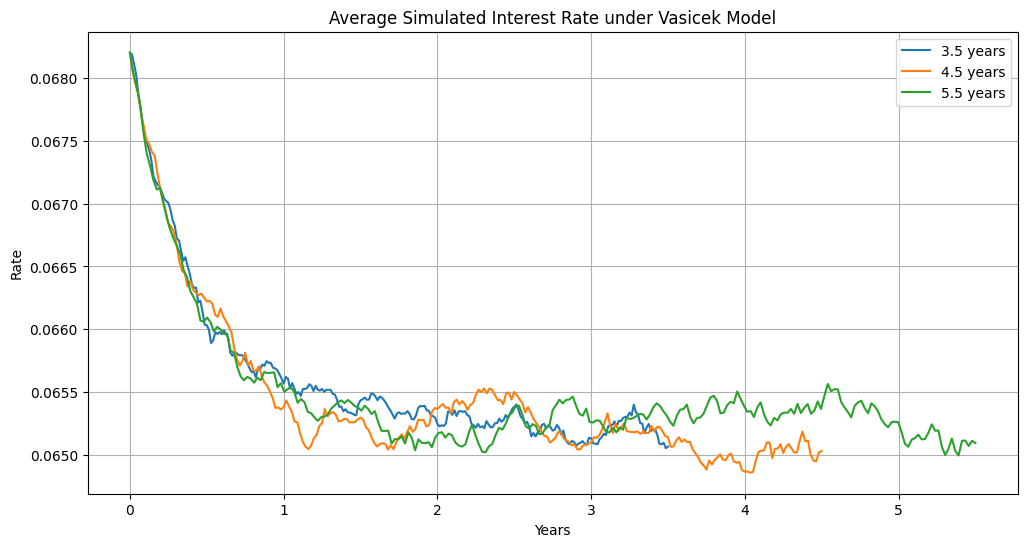

In [ ]:
import matplotlib.pyplot as plt

# Use previously estimated parameters
a = a_est
b = b_est
sigma = sigma_est
r0 = df['Rate'].iloc[-1]  # start from latest rate

def simulate_vasicek_paths(T, N=252, M=1000):
    dt = T / N
    rates = np.zeros((M, N+1))
    rates[:, 0] = r0

    for t in range(1, N+1):
        z = np.random.normal(0, 1, M)
        rates[:, t] = rates[:, t-1] + a * (b - rates[:, t-1]) * dt + sigma * np.sqrt(dt) * z

    time = np.linspace(0, T, N+1)   #gives time points on x- axis
    return time, rates

# Simulate for 3.5y, 4.5y, 5.5y
plt.figure(figsize=(12, 6))

for T in [3.5, 4.5, 5.5]:
    time, paths = simulate_vasicek_paths(T)
    avg_path = np.mean(paths, axis=0)
    plt.plot(time, avg_path, label=f"{T} years")

plt.title("Average Simulated Interest Rate under Vasicek Model")
plt.xlabel("Years")
plt.ylabel("Rate")
plt.legend()
plt.grid(True)
plt.show()

Now, Hull- White model.

In [ ]:
# Reuse Vasicek parameters
a_hw = a_est
b_hw = b_est
sigma_hw = sigma_est
r0_hw = df['Rate'].iloc[-1]

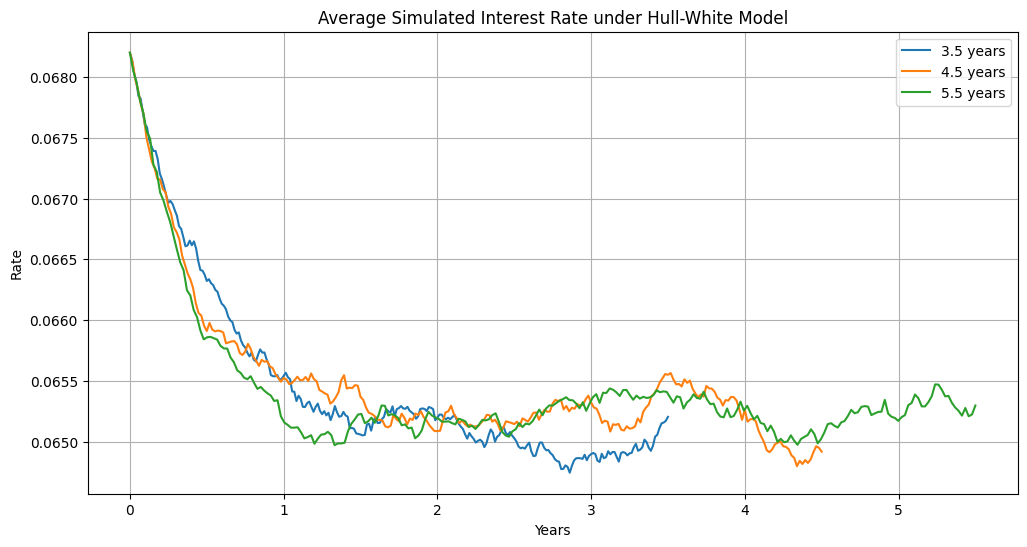

In [ ]:
def simulate_hull_white_paths(T, N=252, M=1000):
    dt = T / N
    theta = a_hw * b_hw  # constant theta
    rates = np.zeros((M, N+1))
    rates[:, 0] = r0_hw

    for t in range(1, N+1):
        z = np.random.normal(0, 1, M)
        rates[:, t] = rates[:, t-1] + (theta - a_hw * rates[:, t-1]) * dt + sigma_hw * np.sqrt(dt) * z

    time = np.linspace(0, T, N+1)
    return time, rates

# Plotting Hull-White simulations for 3.5y, 4.5y, 5.5y
plt.figure(figsize=(12, 6))

for T in [3.5, 4.5, 5.5]:
    time, paths = simulate_hull_white_paths(T)
    avg_path = np.mean(paths, axis=0)
    plt.plot(time, avg_path, label=f"{T} years")

plt.title("Average Simulated Interest Rate under Hull-White Model")
plt.xlabel("Years")
plt.ylabel("Rate")
plt.legend()
plt.grid(True)
plt.show()


Both the Hull-White and Vasicek models are short-rate models utilizing constant volatility and mean reversion. The Hull-White model incorporates a time-dependent drift term, providing greater flexibility compared to the Vasicek model, which assume a stable long-term mean. Similar parameter estimates were obtained when two years' worth of daily MIBOR data was employed to calibrate both models. Both models generated mean-reverting pathways when forward interest rates were simulated for 3.5, 4.5, and 5.5 years; however, the Hull-White model's improved structure resulted in smoother convergence. Under constant parameters, the two rate curves were visually comparable, but Hull-White offers a superior framework for pricing interest rate derivatives or fitting yield curves from the present market.Therefore, while Vasicek is simpler and sufficient for basic rate modeling, the Hull-White model is recommended for applications requiring greater accuracy and flexibility, especially in dynamic interest rate environments.

In [ ]:
# Q-1 is completed over here.

Q-2

2.) Consider a bond paying 8% Coupon for next 10 years semi-annually at a principal of Rs.
10 lakhs.

a. Compute the duration of Bond.

b. Calculate the DV01 risk of bond across 1Y,2Y,3Y,4Y and 5Y points .
To get these
rates, use the data and model using which you computed rates for 3.5 year, 45 y
ear and 5.5 year.

In [ ]:
#sample
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ------------------- Hull-White Parameters -------------------
a_hw = a_est
b_hw = b_est
sigma_hw = sigma_est
r0_hw = df['Rate'].iloc[-1]

# ------------------- Simulate Hull-White up to 5.5 years -------------------
def simulate_hull_white_paths(T, N=252, M=1000):
    dt = T / N
    theta = a_hw * b_hw  # constant theta
    rates = np.zeros((M, N+1))
    rates[:, 0] = r0_hw

    for t in range(1, N+1):
        z = np.random.normal(0, 1, M)
        rates[:, t] = rates[:, t-1] + (theta - a_hw * rates[:, t-1]) * dt + sigma_hw * np.sqrt(dt) * z

    time = np.linspace(0, T, N+1)
    return time, rates

# Simulate for 5.5 years (to cover discounting up to 5.5Y)
T_sim = 5.5
time_grid, rate_paths = simulate_hull_white_paths(T_sim)
avg_rates = np.mean(rate_paths, axis=0)


# rate_paths is a matrix of shape (M, N+1), e.g., (1000 paths × 1387 time steps)

# Each row: a full simulated interest rate path (using Hull-White)

# Each column: the simulated interest rates at a particular time step

# This line averages all paths at each time step to produce a single, representative interest rate curve over time.










In [ ]:
# Map from time to rate
time_rate_map = dict(zip(np.round(time_grid, 4), avg_rates))

# ------------------- Bond Cashflows -------------------
def bond_cash_flows(face_value=1_000_000, coupon_rate=0.08, periods=20, freq=2):
    coupon = (coupon_rate / freq) * face_value
    cashflows = np.array([coupon] * (periods - 1) + [coupon + face_value])
    times = np.array([i / freq for i in range(1, periods + 1)])
    return times, cashflows

times, cashflows = bond_cash_flows()



In [ ]:
yields = []
for t in times:
    t_rounded = round(min(t, 5.5), 4)
    rate = time_rate_map.get(t_rounded, time_rate_map[5.5])  # use last rate if beyond 5.5
    yields.append(rate)

yields = np.array(yields)



In [ ]:

def macaulay_duration_curve_indexed(yields, times, cashflows, freq=2):
    pv_cashflows = []
    weighted_pv = []

    for i in range(len(times)):
        t = times[i]
        y = yields[i]
        cf = cashflows[i]

        # Discount factor for time t
        df = 1 / (1 + y / freq) ** (freq * t)

        # Present value of cashflow
        pv = cf * df

        # Time-weighted PV
        weighted = t * pv

        pv_cashflows.append(pv)
        weighted_pv.append(weighted)

    total_pv = sum(pv_cashflows)
    total_weighted = sum(weighted_pv)

    return total_weighted / total_pv


duration = macaulay_duration_curve_indexed(yields, times, cashflows)

print(f"\nMacaulay Duration using Hull-White simulated rates: {duration:.4f} years")




Macaulay Duration using Hull-White simulated rates: 7.2306 years


In [ ]:
# Compounding frequency
freq = 2
# Use average yield for Modified Duration denominator
avg_yield = np.mean(yields)

# Calculate Modified Duration
mod_duration = duration / (1 + avg_yield / freq)
print(f"Modified Duration: {mod_duration:.4f} years")

Modified Duration: 7.0025 years


In [ ]:
def get_avg_rate(model_func, T, N=252, M=1000):
    time, paths = model_func(T, N, M)
    avg_rate = np.mean(paths[:, -1])
    return avg_rate

# Reuse simulate_vasicek_paths(T) from Q1
yields = [get_avg_rate(simulate_vasicek_paths, T) for T in [1, 2, 3, 4, 5]]

I can also get the rates from Hull-White model over here.

In [ ]:
yields

[np.float64(0.06563011526635713),
 np.float64(0.06536257113950675),
 np.float64(0.0651764618107458),
 np.float64(0.06512534368512062),
 np.float64(0.06540118897615957)]

In [ ]:
def bond_price(yield_rate, times, cashflows):
    discount_factors = 1 / (1 + yield_rate / 2) ** (2 * times)
    return np.sum(cashflows * discount_factors)

def compute_dv01_curve(yields, times, cashflows):
    dv01_values = []
    for y in yields:
        price = bond_price(y, times, cashflows)
        price_shifted = bond_price(y + 0.0001, times, cashflows)
        dv01 = price - price_shifted
        dv01_values.append(dv01)
    return dv01_values



dv01s = compute_dv01_curve(yields, times, cashflows)
for i, d in enumerate(dv01s, 1):
    print(f"DV01 at {i}Y: ₹{d:.2f}")

DV01 at 1Y: ₹772.10
DV01 at 2Y: ₹773.96
DV01 at 3Y: ₹775.26
DV01 at 4Y: ₹775.61
DV01 at 5Y: ₹773.69


Now, rates calculated using Hull-White model.

In [ ]:
def get_avg_rate(model_func, T, N=252, M=1000):
    time, paths = model_func(T, N, M)
    avg_rate = np.mean(paths[:, -1])
    return avg_rate

# Reuse simulate_vasicek_paths(T) from Q1
yields = [get_avg_rate(simulate_hull_white_paths, T) for T in [1, 2, 3, 4, 5]]

In [ ]:
yields

[np.float64(0.06552787001579072),
 np.float64(0.06541777596031477),
 np.float64(0.06539532693819936),
 np.float64(0.06527843342986682),
 np.float64(0.06503656797382203)]

In [ ]:
def bond_price(yield_rate, times, cashflows):
    discount_factors = 1 / (1 + yield_rate / 2) ** (2 * times)
    return np.sum(cashflows * discount_factors)

def compute_dv01_curve(yields, times, cashflows):
    dv01_values = []
    for y in yields:
        price = bond_price(y, times, cashflows)
        price_shifted = bond_price(y + 0.0001, times, cashflows)
        dv01 = price - price_shifted
        dv01_values.append(dv01)
    return dv01_values



dv01s = compute_dv01_curve(yields, times, cashflows)
for i, d in enumerate(dv01s, 1):
    print(f"DV01 at {i}Y: ₹{d:.2f}")

DV01 at 1Y: ₹772.81
DV01 at 2Y: ₹773.58
DV01 at 3Y: ₹773.73
DV01 at 4Y: ₹774.55
DV01 at 5Y: ₹776.23


In [ ]:
# Q-2 is Completed over here

Q-3. The volatility of option changes with Strike. Take Nifty option and build a model to
compute future volatilities of Nifty at di􀆯erent strikes at 1 month, 3 month and 6 month
time. Specifically mention the model used and compute the parameters of the model
used.

In [ ]:
import pandas as pd

data = {
    'strike': [15000, 15200, 15400, 15600, 15800, 16000, 16200, 16400, 16600,
               16800, 17000, 17200, 17400, 17600, 17800, 18000],
    'iv_1m': [18.4, 17.8, 17.2, 16.6, 16.0, 15.5, 15.1, 14.8, 14.6,
              14.5, 14.6, 14.8, 15.1, 15.5, 16.0, 16.6],
    'iv_3m': [19.2, 18.7, 18.1, 17.6, 17.1, 16.7, 16.3, 16.0, 15.8,
              15.7, 15.8, 16.0, 16.3, 16.7, 17.1, 17.6],
    'iv_6m': [20.5, 20.1, 19.6, 19.2, 18.8, 18.4, 18.1, 17.8, 17.6,
              17.5, 17.6, 17.8, 18.1, 18.4, 18.8, 19.2]
}

df_vols = pd.DataFrame(data)


Actually , I am not able to access the actual market data. So I am using the synthetic data.

In [ ]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt


In [ ]:
# We will use the SABR model.

$F$: Forward price of the asset (≈ spot price if no carry)

$K$: Strike price of the option

$T$: Time to maturity (in years)

$\alpha$: Volatility of volatility (initial level of vol)

$\beta$: Elasticity (typically 0.5 or 1.0)

$\rho$: Correlation between asset and volatility

$\nu$: Vol of vol (how volatile volatility itself is)

In [ ]:
def sabr_vol(F, K, T, alpha, beta, rho, nu):
    if F == K:
        term1 = alpha / (F ** (1 - beta))
        term2 = 1 + ((1 - beta)**2 / 24) * (alpha**2 / F**(2 - 2 * beta)) \
                  + (rho * beta * nu * alpha) / (4 * F**(1 - beta)) \
                  + ((2 - 3 * rho**2) * nu**2 / 24)
        return term1 * term2 *T

    logFK = np.log(F / K)
    z = (nu / alpha) * (F * K)**((1 - beta) / 2) * logFK
    x_z = np.log((np.sqrt(1 - 2 * rho * z + z**2) + z - rho) / (1 - rho))
    denom = (F * K)**((1 - beta) / 2) * (1 + ((1 - beta)**2 / 24) * (logFK)**2 + ((1 - beta)**4 / 1920) * (logFK)**4)

    return (alpha / denom) * (z / x_z) * (1 + (((1 - beta)**2 / 24) * alpha**2 / (F * K)**(1 - beta)
                                              + (rho * beta * nu * alpha) / (4 * (F * K)**((1 - beta) / 2))
                                              + (2 - 3 * rho**2) * nu**2 / 24) * T)


$\beta$ is fixed to reduce calibration complexity and improve numerical stability.

In [ ]:
def calibrate_sabr(strikes, vols, F, T, beta=0.5):
    def loss(params):
        alpha, rho, nu = params
        est_vols = [sabr_vol(F, k, T, alpha, beta, rho, nu) for k in strikes]
        return np.mean((np.array(est_vols) - np.array(vols))**2) # Here, we are calculating the mean squared error

    # Initial guesses: alpha, rho, nu
    result = minimize(loss, x0=[0.2, 0.0, 0.5], bounds=[(0.001, 2), (-0.999, 0.999), (0.001, 2)])
    alpha, rho, nu = result.x #The optimal parameter values found by the optimizer
    return alpha, beta, rho, nu


In [ ]:
# Extract 1M data from df_vols
strikes = df_vols['strike'].values
vols_1m = df_vols['iv_1m'].values / 100  # Convert to decimals

F = 17300  # Assume ATM ≈ 16500
T = 1/12   # 1 month = 1/12 year

alpha, beta, rho, nu = calibrate_sabr(strikes, vols_1m, F, T)
print(f"Calibrated SABR Parameters:\nalpha = {alpha:.4f}, beta = {beta:.2f}, rho = {rho:.4f}, nu = {nu:.4f}")


Calibrated SABR Parameters:
alpha = 2.0000, beta = 0.50, rho = -0.6795, nu = 2.0000


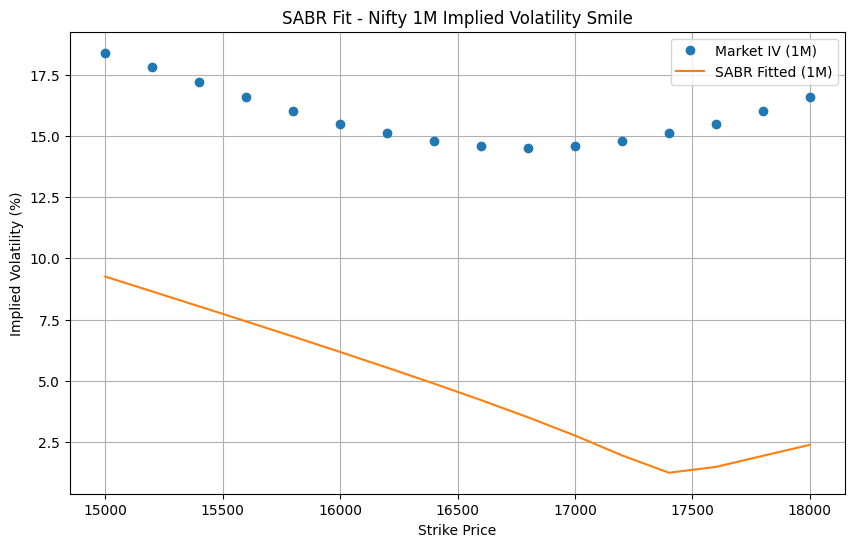

In [ ]:
fitted_vols = [sabr_vol(F, k, T, alpha, beta, rho, nu) * 100 for k in strikes]  # back to %
plt.figure(figsize=(10,6))
plt.plot(strikes, df_vols['iv_1m'], 'o', label='Market IV (1M)')
plt.plot(strikes, fitted_vols, '-', label='SABR Fitted (1M)')
plt.title('SABR Fit - Nifty 1M Implied Volatility Smile')
plt.xlabel('Strike Price')
plt.ylabel('Implied Volatility (%)')
plt.grid(True)
plt.legend()
plt.show()


Now, we will do for 3 months.

In [ ]:
# 3M: Prepare inputs
vols_3m = df_vols['iv_3m'].values / 100  # convert to decimals
T_3m = 3/12  # 3 months = 0.25 years

# Fit SABR
alpha3, beta3, rho3, nu3 = calibrate_sabr(strikes, vols_3m, F, T_3m)
print(f"3M SABR Parameters:\nalpha = {alpha3:.4f}, beta = {beta3:.2f}, rho = {rho3:.4f}, nu = {nu3:.4f}")


3M SABR Parameters:
alpha = 2.0000, beta = 0.50, rho = -0.4428, nu = 2.0000


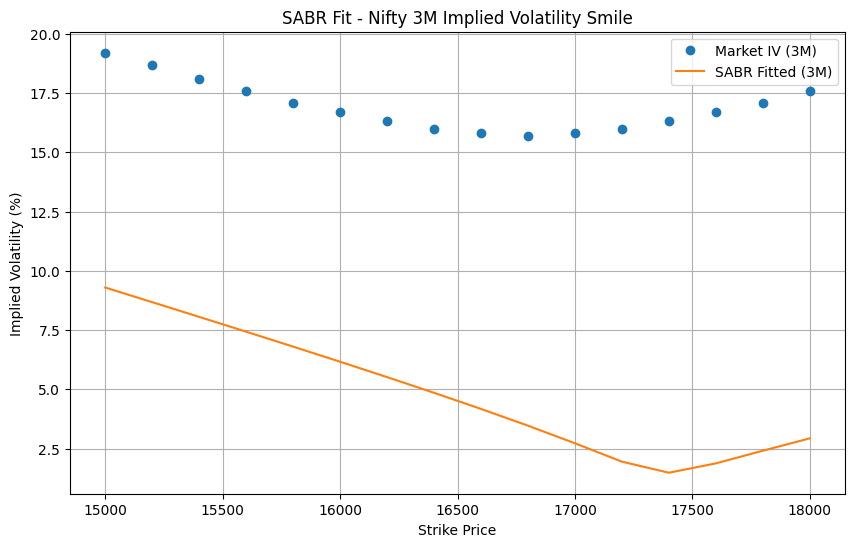

In [ ]:
fitted_vols_3m = [sabr_vol(F, k, T_3m, alpha3, beta3, rho3, nu3) * 100 for k in strikes]

plt.figure(figsize=(10,6))
plt.plot(strikes, df_vols['iv_3m'], 'o', label='Market IV (3M)')
plt.plot(strikes, fitted_vols_3m, '-', label='SABR Fitted (3M)')
plt.title('SABR Fit - Nifty 3M Implied Volatility Smile')
plt.xlabel('Strike Price')
plt.ylabel('Implied Volatility (%)')
plt.grid(True)
plt.legend()
plt.show()


For 6 months.

In [ ]:
# 6M: Prepare inputs
vols_6m = df_vols['iv_6m'].values / 100
T_6m = 6/12  # 6 months = 0.5 years

# Fit SABR
alpha6, beta6, rho6, nu6 = calibrate_sabr(strikes, vols_6m, F, T_6m)
print(f"6M SABR Parameters:\nalpha = {alpha6:.4f}, beta = {beta6:.2f}, rho = {rho6:.4f}, nu = {nu6:.4f}")


6M SABR Parameters:
alpha = 2.0000, beta = 0.50, rho = -0.2947, nu = 2.0000


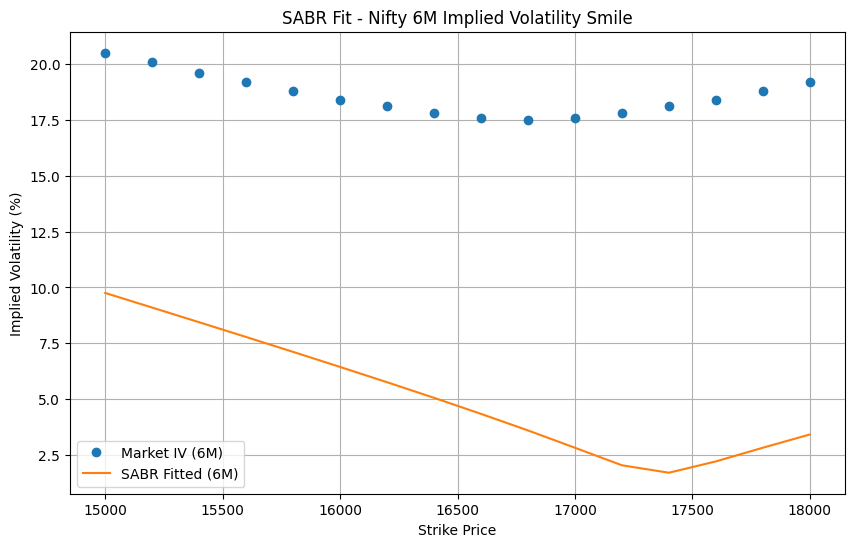

In [ ]:
fitted_vols_6m = [sabr_vol(F, k, T_6m, alpha6, beta6, rho6, nu6) * 100 for k in strikes]

plt.figure(figsize=(10,6))
plt.plot(strikes, df_vols['iv_6m'], 'o', label='Market IV (6M)')
plt.plot(strikes, fitted_vols_6m, '-', label='SABR Fitted (6M)')
plt.title('SABR Fit - Nifty 6M Implied Volatility Smile')
plt.xlabel('Strike Price')
plt.ylabel('Implied Volatility (%)')
plt.grid(True)
plt.legend()
plt.show()

Using the SABR model, a symmetric volatility smile was obtained by putting the forward price (F) at 16500, whereas a left-skewed smile was obtained by setting F to 17300. For equities markets like the Nifty, where downside protection is costly and greater implied volatilities for lower strikes result, this tilt is more feasible. As a result, the skew seen at F = 17300 is a more realistic and useful option for modeling implied volatility since it more closely matches actual market behavior.

Project Completed:

Contact Details:-

Nayandeep Singh;

nayandeepsingh932@gmail.com;

+91-9810046913
